Analysis for Dataset to understand student stress and anxiety levels


Installing the required dependencies


In [ ]:
#Installing the dependencies
!pip install wordcloud
import csv
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly as pl
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from matplotlib.patches import Patch

# Import custom modules
import sys
sys.path.append('..\module')
import categorize_data as cd
import visualization as vz


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14244\204031271.py:19: SyntaxWarning: invalid escape sequence '\m'
  sys.path.append('..\module')


In [2]:
#Reading the primary data csv
current_directory = os.getcwd()
print(current_directory)
df = pd.read_csv("./../Data/cleaned_data.csv", encoding = 'ISO-8859-1')

c:\Users\Lenovo\ECE143_project\Analysis


In [14]:
df.head()
#Displaying the data

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,SWL1,SWL2,...,Gender,Age,Work,Degree,Reference,Playstyle,GAD_T,SWL_T,SPIN_T,Residence_ISO3
0,0,0,0,0,1,0,0,Not difficult at all,3,5,...,Male,25,Unemployed / between jobs,BachelorÂ (or equivalent),Reddit,singleplayer,1,23,5.0,USA
1,1,2,2,2,0,1,0,Somewhat difficult,3,5,...,Male,41,Unemployed / between jobs,BachelorÂ (or equivalent),Reddit,multiplayer online with strangers,8,16,33.0,USA
2,0,0,0,0,0,0,0,Not difficult at all,2,5,...,Male,28,Employed,BachelorÂ (or equivalent),Reddit,multiplayer online with online acquaintances...,0,17,11.0,USA
3,2,1,2,2,2,3,2,Very difficult,2,2,...,Male,19,Employed,High school diploma (or equivalent),Reddit,multiplayer online with strangers,14,14,13.0,KOR
4,0,0,0,0,0,1,0,Not difficult at all,3,5,...,Male,24,Employed,BachelorÂ (or equivalent),Reddit,multiplayer online with real life friends,1,17,13.0,USA


In [15]:
#Understanding what columns are present in the data
df.columns

Index(['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GADE', 'SWL1',
       'SWL2', 'SWL3', 'SWL4', 'SWL5', 'Game', 'Platform', 'Hours', 'earnings',
       'whyplay', 'League', 'streams', 'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4',
       'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8', 'SPIN9', 'SPIN10', 'SPIN11',
       'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17',
       'Narcissism', 'Gender', 'Age', 'Work', 'Degree', 'Reference',
       'Playstyle', 'GAD_T', 'SWL_T', 'SPIN_T', 'Residence_ISO3'],
      dtype='object')

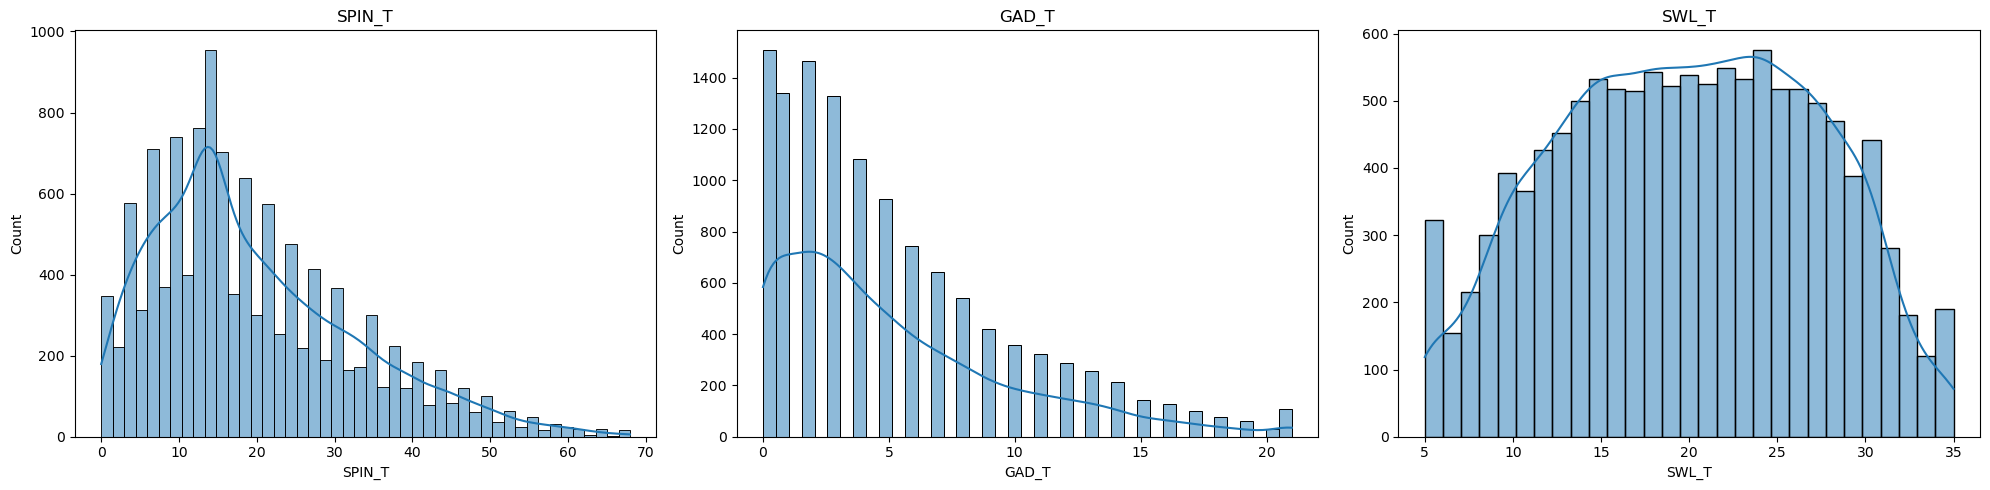

In [16]:
#Plotting density distribution for the SPIN, SWL and GAD scores in the dataset
labels = ['SPIN_T', 'GAD_T', 'SWL_T']
fig, axes = plt.subplots(1, len(labels), figsize=(20, 5))
for i, col in enumerate(labels):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"{col}")

plt.tight_layout()
plt.show()

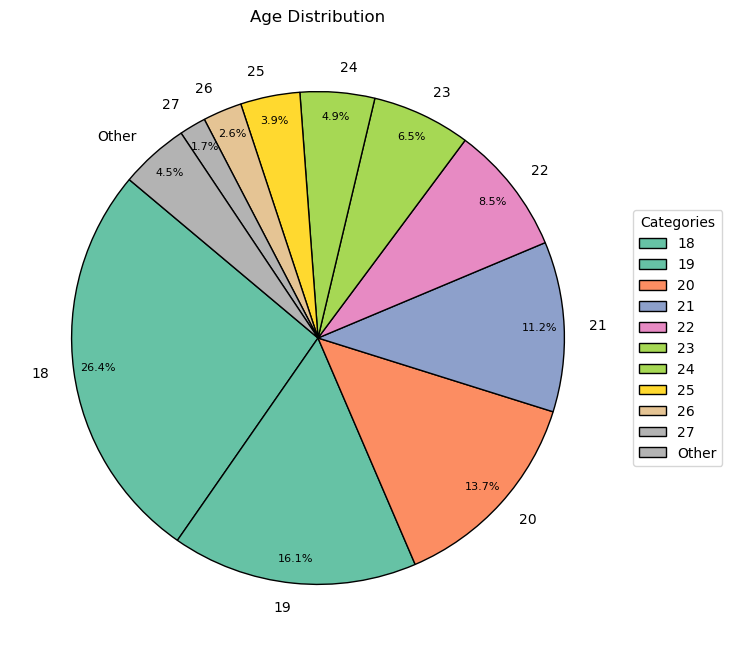

In [17]:
#Plotting a pie chart to see Age distribution in the data
age_counts = df['Age'].value_counts().reset_index()
age_counts.columns = ['Age', 'Count']
top_n = 10

# Group the remaining age groups as 'Other' if necessary
if len(age_counts) > top_n:
    
    other_count = age_counts.iloc[top_n:]['Count'].sum()
    age_counts = age_counts.iloc[:top_n]
    age_counts.loc[len(age_counts)] = ['Other', other_count]

# Plot the pie chart
vz.plot_piechart(labels=age_counts['Age'], values=age_counts['Count'], title='Age Distribution')

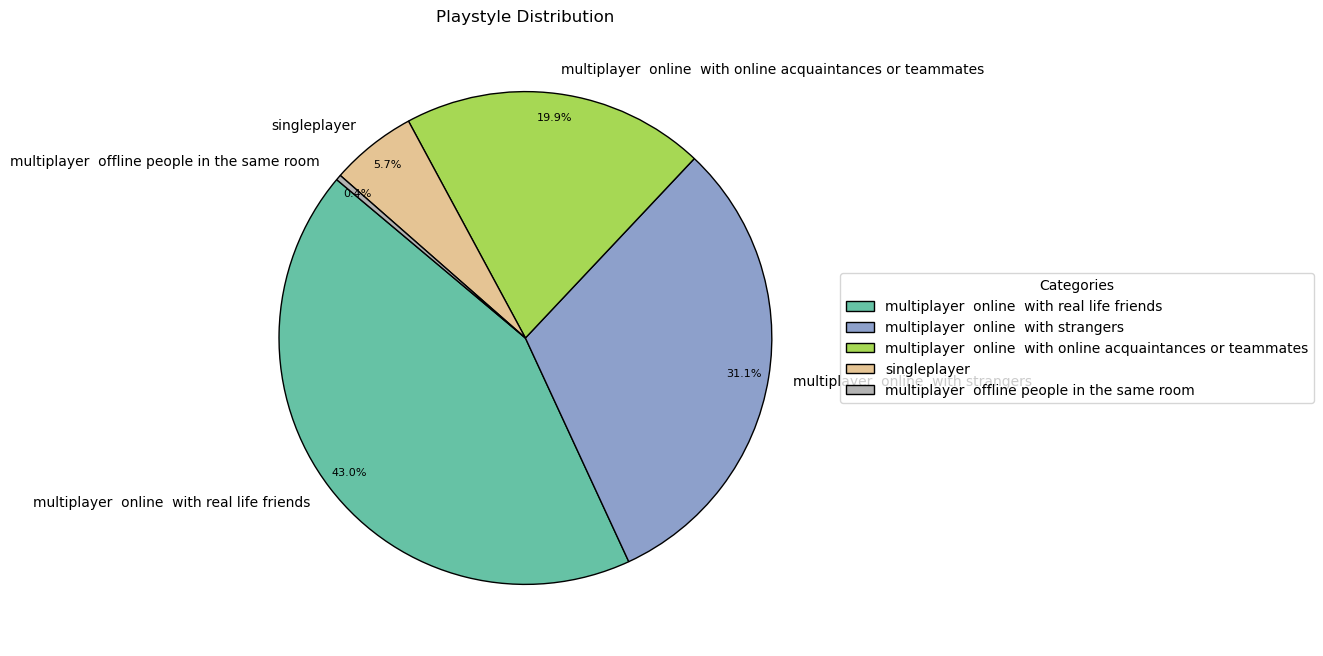

In [18]:
#Piechart reflecting multiple playstyles present in the data

vz.plot_piechart(labels=df['Playstyle'].value_counts().index, values=df['Playstyle'].value_counts().values, title='Playstyle Distribution')

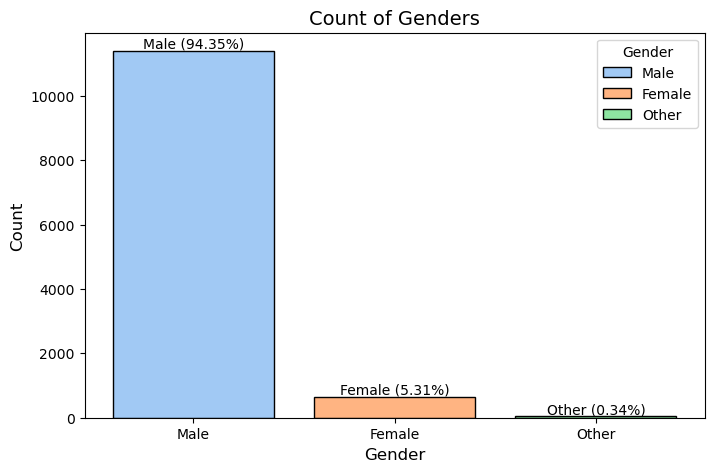

In [ ]:
# Plots the gender distribution in the dataset.

 # Calculate gender counts and percentages
gender_counts = df['Gender'].value_counts()
total_count = gender_counts.sum()
percentages = (gender_counts / total_count * 100).round(2)
labels = [f"{gender} ({percent}%)" for gender, percent in zip(gender_counts.index, percentages)]

# Defining colors for the bar char
colors = ['cornflowerblue', 'lightsalmon'] if len(gender_counts) == 2 else sns.color_palette("pastel")

#plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(gender_counts.index, gender_counts.values, color=colors, edgecolor='black')

for bar, label in zip(bars, labels):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), label, ha='center', va='bottom', fontsize=10)

plt.legend(bars, gender_counts.index, title="Gender", loc="upper right")
plt.title("Count of Genders", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.show()

Now that we are aware of the data present in the survey, we'll take a look at the relations between the following factors:
1) Games played and GAD scores
2) GAD with Satisfaction of Life
3) Degree level with Satisfaction of Life
4) Hours of gaming vs Area of Residence
5) SPIN and Gaming Playstyle


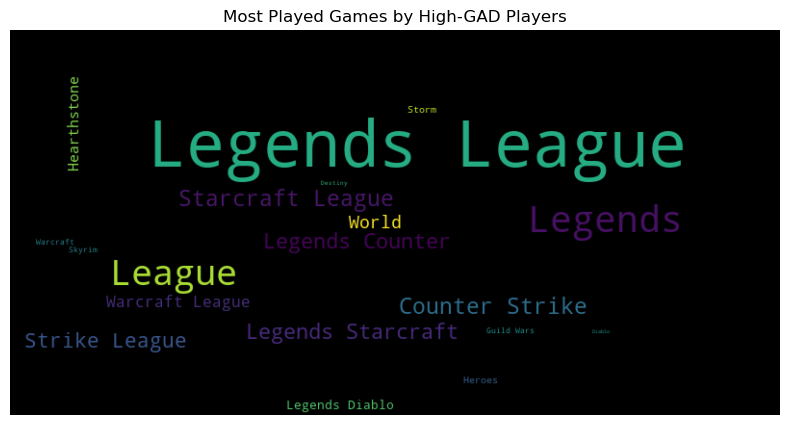

In [20]:
#Visualizing a relation between Games played + GAD scores 

#Join the game column
high_gad_games = " ".join(df[df["GAD_T"] > df["GAD_T"].median()]["Game"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(high_gad_games)

#Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Played Games by High-GAD Players")
plt.show()

In [3]:
# Categorizing some columns of data to get better analysis
data_categorized = cd.categorize_data(df)

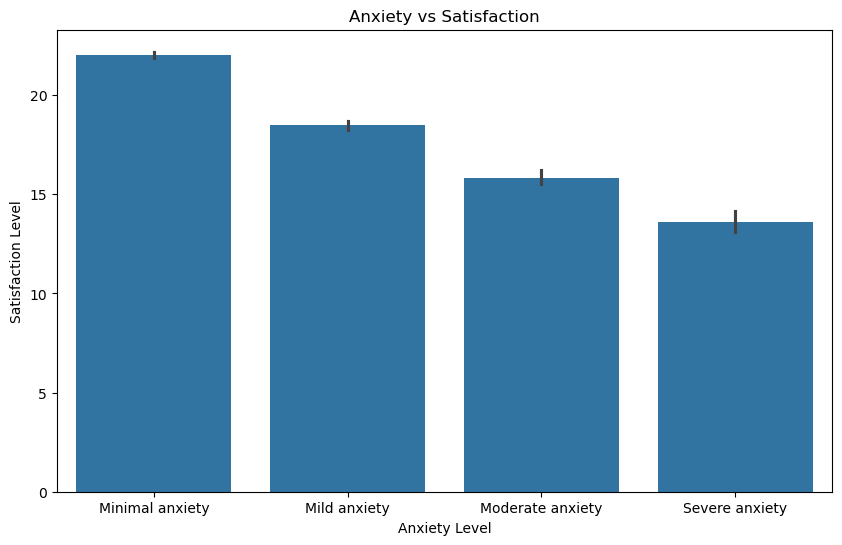

In [4]:
#Plotting the relation between Anxiety and Life Satisfaction Life
vz.plot_barplot(data=data_categorized, x='Anxiety_level', y='SWL_T', title='Anxiety vs Satisfaction', xlabel='Anxiety Level', ylabel='Satisfaction Level')

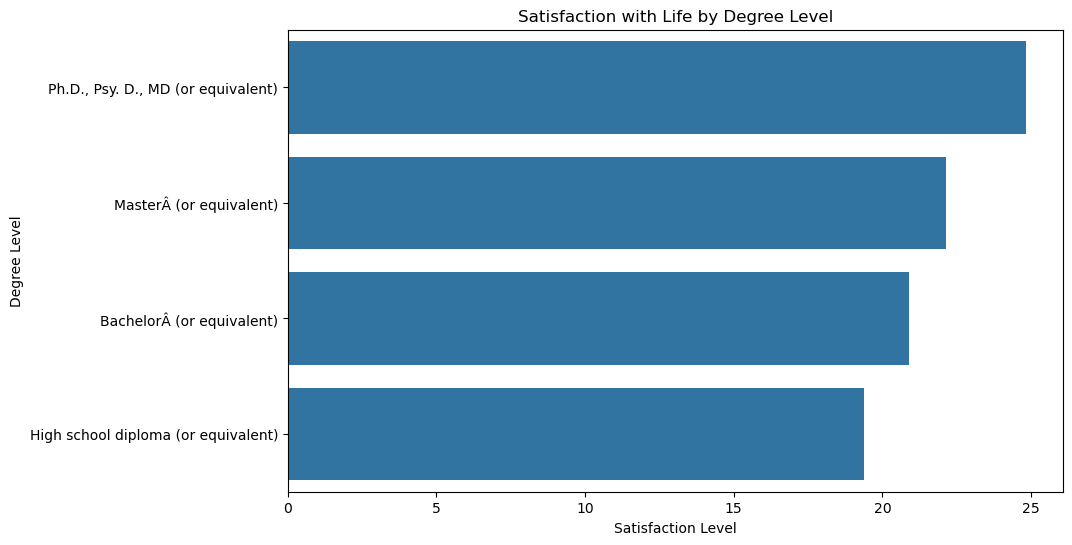

In [5]:
# Aggregate mean Satisfaction with Life (SWL_T) by Degree category
swl_by_degree = data_categorized.groupby("Degree")["SWL_T"].mean().reset_index()

# Sort by satisfaction scores for better visualization
swl_by_degree = swl_by_degree.sort_values(by="SWL_T", ascending=False)
vz.plot_barplot(data=swl_by_degree, x='SWL_T', y='Degree', title='Satisfaction with Life by Degree Level', xlabel='Satisfaction Level', ylabel='Degree Level')


count    12081.000000
mean        21.154375
std         12.953346
min          0.000000
25%         12.000000
50%         20.000000
75%         28.000000
max        110.000000
Name: Hours, dtype: float64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14244\639578591.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=legit_hour_df[legit_hour_df['Residence_ISO3'].isin(residence_hours.index)],


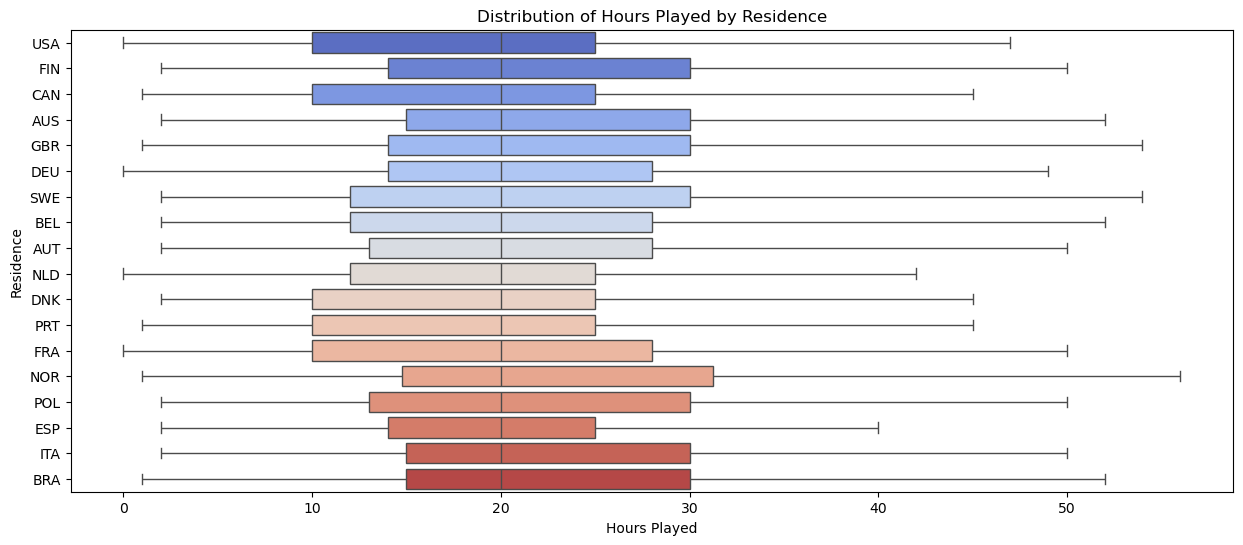

In [6]:
#Plots the platform distribution in the dataset.
platform_counts = df['Platform'].value_counts().rename_axis('platform').reset_index(name='count')
platform_counts

#Describing hours played 
print(df['Hours'].describe())

#Defining maximum hours per week
max_hours_week = 24 * 7

legit_hour_df = df.query('Hours <= @max_hours_week')
residence_hours = legit_hour_df.groupby('Residence_ISO3').Hours.agg(['mean', 'size']).query('Residence_ISO3 != "Unknown" & size >= 100')
residence_hours.sort_values(by=['mean'], ascending=[False], inplace=True)

#Creating the box plot
plt.figure(figsize=(15, 6))
sns.boxplot(data=legit_hour_df[legit_hour_df['Residence_ISO3'].isin(residence_hours.index)], 
            x='Hours', y='Residence_ISO3', showfliers=False, palette="coolwarm")
plt.title("Distribution of Hours Played by Residence")
plt.xlabel("Hours Played")
plt.ylabel("Residence")
plt.show()

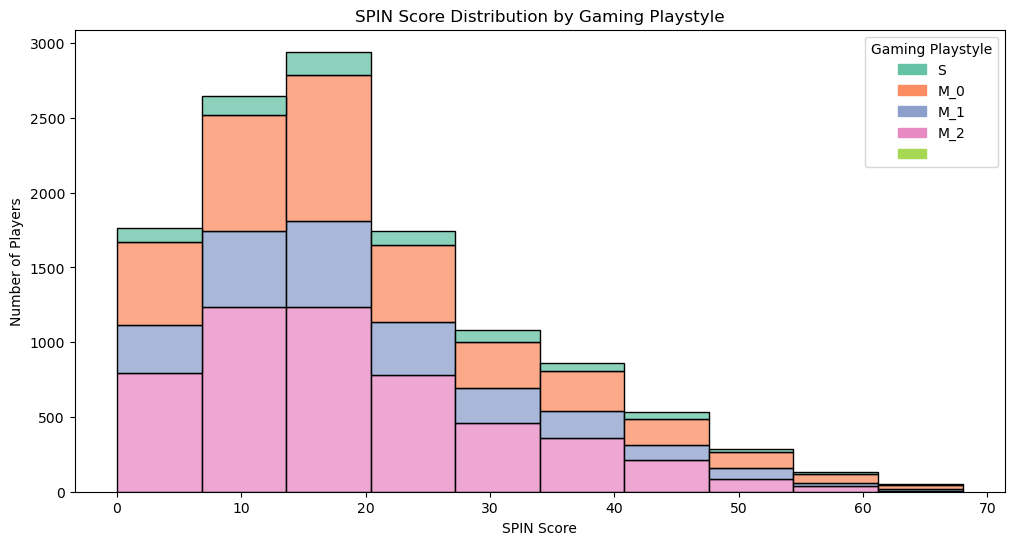

In [ ]:
#Checking relation between playstyle type and mental health scores
playstyles = data_categorized['Play'].unique()
colors = sns.color_palette("Set2", len(playstyles))
legend_patches = [Patch(color=colors[i], label=playstyle) for i, playstyle in enumerate(playstyles)]
plt.figure(figsize=(12, 6))
sns.histplot(data=data_categorized, x="SPIN_T", hue="Play", bins=10, multiple="stack", palette="Set2")

plt.title("SPIN Score Distribution by Gaming Playstyle")
plt.xlabel("SPIN Score")
plt.ylabel("Number of Players")

# setting the legend
plt.legend(handles=legend_patches, title="Gaming Playstyle", loc="upper right")

plt.show()

#Here:
#S: single payer
#M_0: multiplayer  online  with stranger 
#M_1: multiplayer  online  with online acquaintances or teammates
#M_2: multiplayer  online  with real life friends


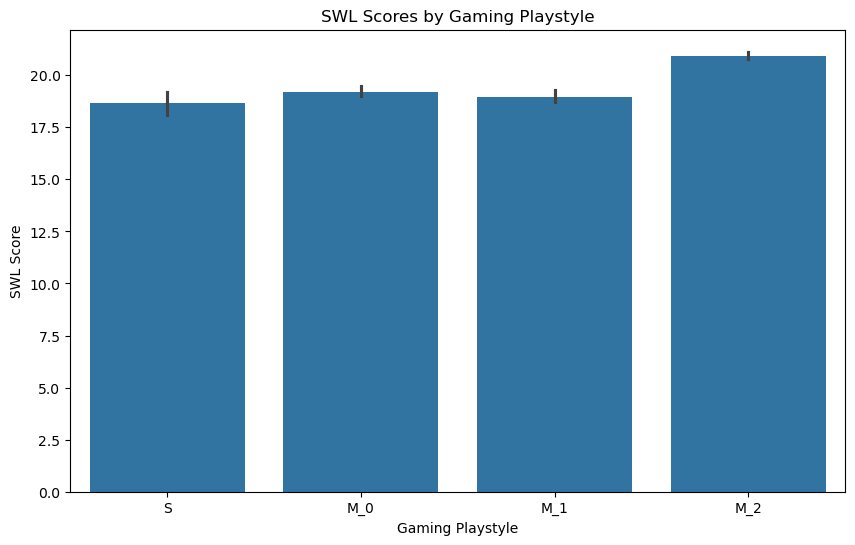

In [8]:
#Plotting SWL vs Gaming Playstyle
vz.plot_barplot(x='Play',
    y='SWL_T',
    data=data_categorized,
    title='SWL Scores by Gaming Playstyle',
    xlabel='Gaming Playstyle',
    ylabel='SWL Score'
)
#Here:
#S: single payer
#M_0: multiplayer  online  with stranger 
#M_1: multiplayer  online  with online acquaintances or teammates
#M_2: multiplayer  online  with real life friends

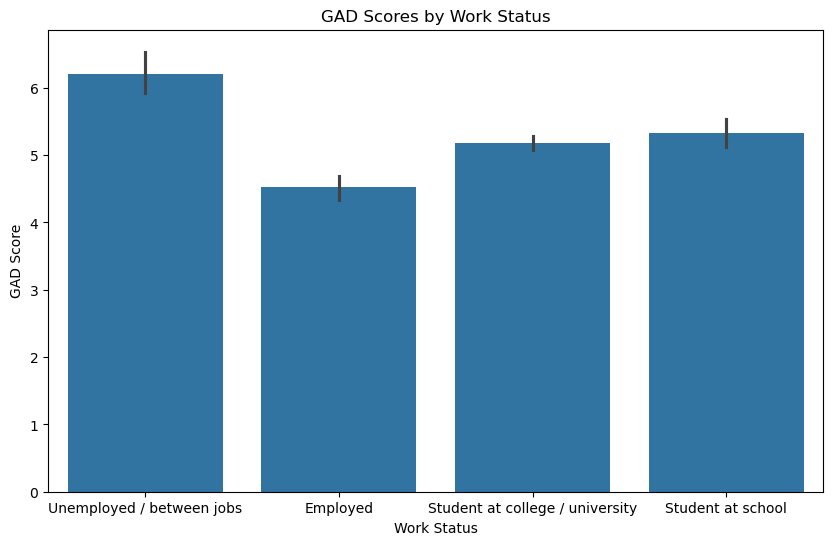

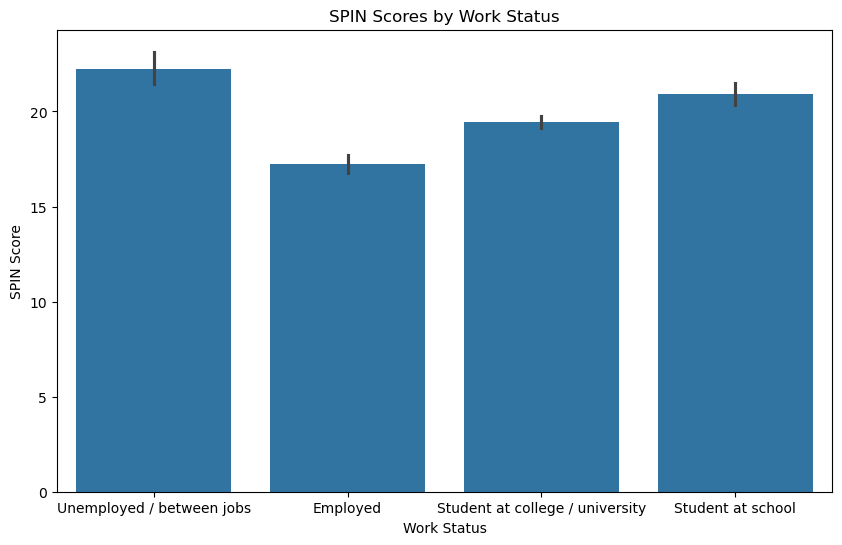

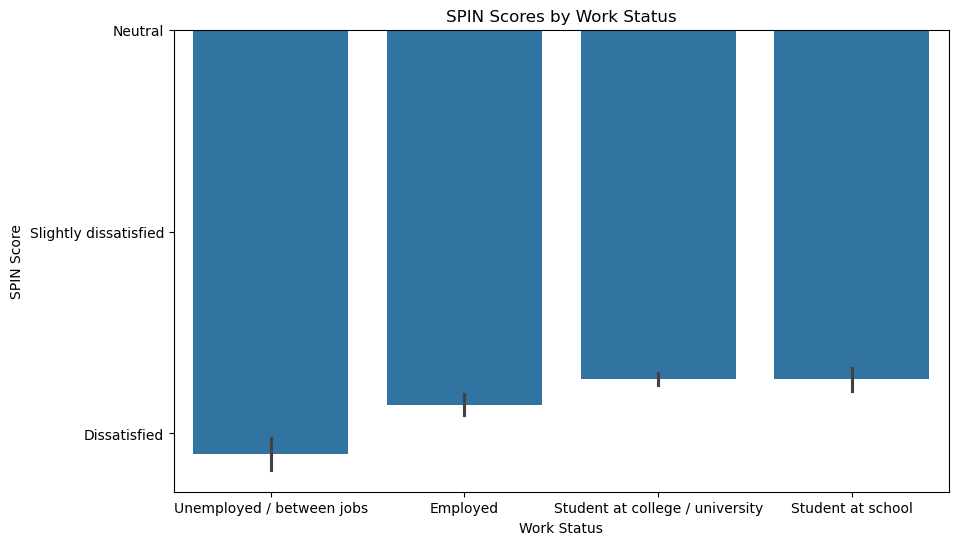

In [9]:
#Plotting relation between work status and GAD SPIN and SWL scores
vz.plot_barplot(x='Work',
    y='GAD_T',
    data=data_categorized,
    title='GAD Scores by Work Status',
    xlabel='Work Status',
    ylabel='GAD Score'
)
vz.plot_barplot(x='Work',
    y='SPIN_T',
    data=data_categorized,
    title='SPIN Scores by Work Status',
    xlabel='Work Status',
    ylabel='SPIN Score'
)
vz.plot_barplot(x='Work',
    y='SWL',
    data=data_categorized,
    title='SPIN Scores by Work Status',
    xlabel='Work Status',
    ylabel='SPIN Score'
)

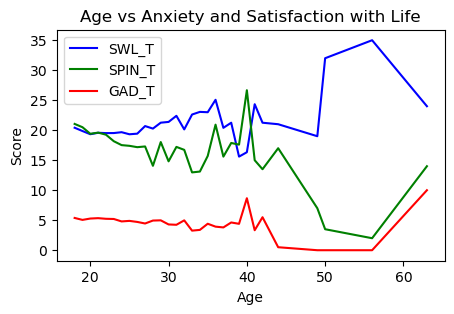

In [10]:
#Relation between various scores as age increases
plt.figure(figsize=(5,3))  

# Define the variables
variables = ['SWL_T', 'SPIN_T', 'GAD_T']
colors = ['b', 'g', 'r']  

#Loop through each variable and plot it
for var, color in zip(variables, colors):
    data_categorized.groupby('Age')[var].mean().plot(label=var, color=color)

# Add title, labels, and legend
plt.title("Age vs Anxiety and Satisfaction with Life")
plt.xlabel("Age")
plt.ylabel("Score")
plt.legend()  # Show legend to differentiate lines

plt.show()

Plotting correlation relationships between different factors and SPIN/SWL/GAD scores

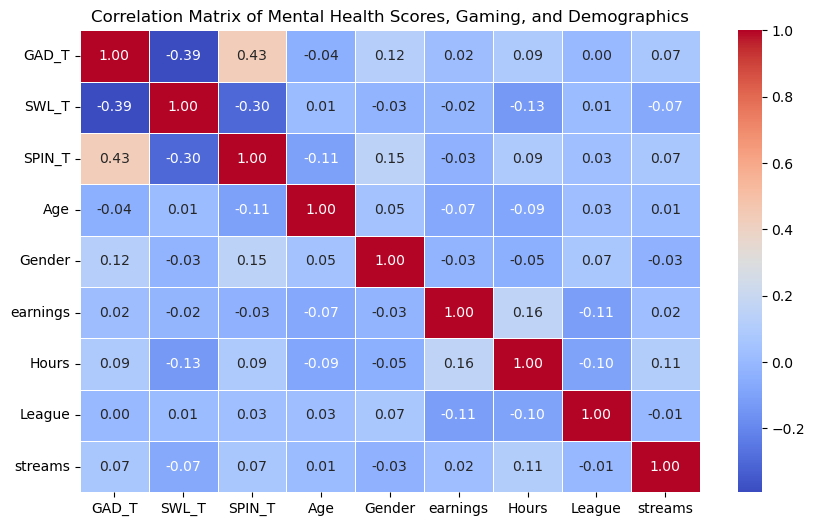

In [ ]:
# Defining the columns for mental health scores, gaming behaviors, and demographics
mental_health_scores = ["GAD_T", "SWL_T", "SPIN_T"]
gaming_behaviors = ["Hours", "League", "streams"]
demographics = ["Age", "Gender", "earnings"]
correlation_matrix = df_encoded[mental_health_scores + demographics + gaming_behaviors].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Mental Health Scores, Gaming, and Demographics")
plt.show()

The following code demonstrates a machine learning workflow for analyzing student mental health scores (GAD_T, SWL_T, SPIN_T) using a Random Forest Regressor.

In [25]:
df_encoded = data_categorized.copy()

# Encode categorical variables
for col in df_encoded.select_dtypes(include=["object"]).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Defining features and target variables
X = df_encoded.drop(columns=["GAD_T", "SWL_T", "SPIN_T"])
y_gad = df_encoded["GAD_T"]
y_swl = df_encoded["SWL_T"]
y_spin = df_encoded["SPIN_T"]

# Splitting the data into training and testing 
X_train_gad, X_test_gad, y_train_gad, y_test_gad = train_test_split(X, y_gad, test_size=0.2, random_state=42)
X_train_swl, X_test_swl, y_train_swl, y_test_swl = train_test_split(X, y_swl, test_size=0.2, random_state=42)
X_train_spin, X_test_spin, y_train_spin, y_test_spin = train_test_split(X, y_spin, test_size=0.2, random_state=42)

#training the random forest regressr for GAD 
gad_model.fit(X_train_gad, y_train_gad)

#Traning for swl 
swl_model.fit(X_train_swl, y_train_swl)

#Training for spin 
spin_model.fit(X_train_spin, y_train_spin)


RandomForestRegressor(random_state=42)

In [26]:
# Making predictions
gad_pred = gad_model.predict(X_test_gad)
swl_pred = swl_model.predict(X_test_swl)
spin_pred = spin_model.predict(X_test_spin)

#evaluation how effective the model is i.e. how accurate are the predictions
gad_mse = mean_squared_error(y_test_gad, gad_pred)
gad_rmse = gad_mse ** 0.5
gad_r2 = r2_score(y_test_gad, gad_pred)

swl_mse = mean_squared_error(y_test_swl, swl_pred)
swl_rmse = swl_mse ** 0.5
swl_r2 = r2_score(y_test_swl, swl_pred)

spin_mse = mean_squared_error(y_test_spin, spin_pred)
spin_rmse = spin_mse ** 0.5
spin_r2 = r2_score(y_test_spin, spin_pred)

print(f"GAD- MSE: {gad_mse}, RMSE: {gad_rmse}, R²: {gad_r2}")
print(f"SWL - MSE: {swl_mse}, RMSE: {swl_rmse}, R²: {swl_r2}")
print(f"SPIN - MSE: {spin_mse}, RMSE: {spin_rmse}, R²: {spin_r2}")



GAD- MSE: 0.26666565990897806, RMSE: 0.5163968047044618, R²: 0.9877387155325137
SWL - MSE: 0.39292858916011586, RMSE: 0.6268401623700541, R²: 0.9921238515876011
SPIN - MSE: 6.012433678113363, RMSE: 2.452026443192113, R²: 0.9652393434182222


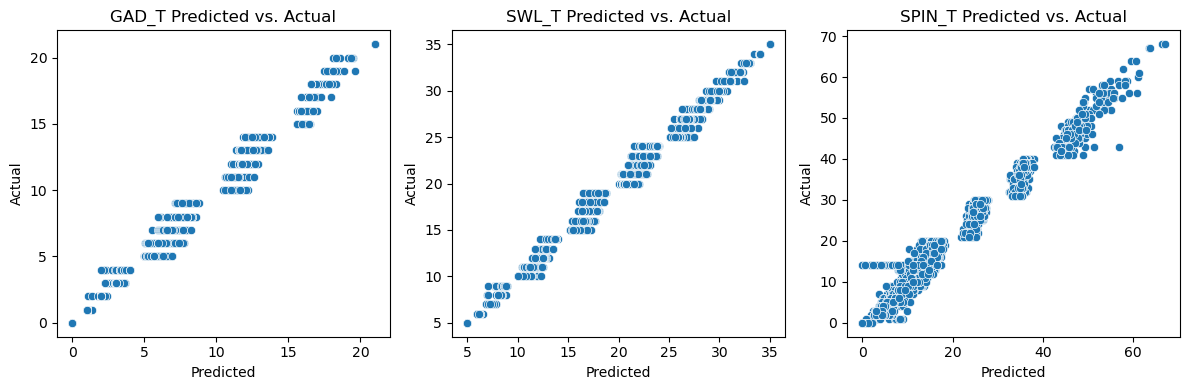

In [27]:
# Predictions for visualization
gad_pred = gad_model.predict(X_test_gad)
swl_pred = swl_model.predict(X_test_swl)
spin_pred = spin_model.predict(X_test_spin)

# Scatter Plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=gad_pred, y=y_test_gad)
plt.title('GAD_T Predicted vs. Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.scatterplot(x=swl_pred, y=y_test_swl)
plt.title('SWL_T Predicted vs. Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.scatterplot(x=spin_pred, y=y_test_spin)
plt.title('SPIN_T Predicted vs. Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()



Now, to understand better what factors contribute to student anxiety (specifically high GAD scores), we take a look at another dataset : Student Stress Level : A comprehensive analysis of various factors that contribute. Understanding this can help us make better recommendations and interventions to the system


The dataset consideres sround 20 factors that are contributing to anxiety level and self esteem among students. 

Psychological Factors => 'anxiety_level', 'self_esteem', 'mental_health_history', 'depression',


Health Factors => 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem


Environmental Factors => 'noise_level', 'living_conditions', 'safety', 'basic_needs',


Academic Factors => 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns',


Social Factor => 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying'

We'll specifically try to analyse what factors are constributing to higher anxiety levels, and hence what steps can be taken to improve the mental health of students.

The scaling of data on a numerical scale is as follows:
1) Anxiety : range from 0 to 21, Measure : GAD-7
2) Self-esteem : range 0 to 30, Measure: Rosenberg Self Esteem Scale
3) Mental Health History : 0 if no mental health history, 1 if mental health history
4) Depression : range 0 to 27, Measure: Patient Health Questionnaire (PHQ-9)
5) Other features mostly range from 0 to 5 considering 0,1 to be low, 2,3 to be mid, and 4,5 to be high.


In [14]:
secondary_data = pd.read_csv("./../Data/StressLevelDataset.csv", encoding = 'ISO-8859-1')
secondary_data.head()
secondary_data.info()
secondary_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


In [15]:
#Finding out how many students were considered in the survey an dhow many hav ereported mental health issues
print("There are", len(secondary_data), "students in the dataset.")
print("The avarage anxiety level is:", round(secondary_data.anxiety_level.mean(),2))
print(len(secondary_data.loc[secondary_data.mental_health_history == 1]), "students reported a history of mental health issues.")


There are 1100 students in the dataset.
The avarage anxiety level is: 11.06
542 students reported a history of mental health issues.


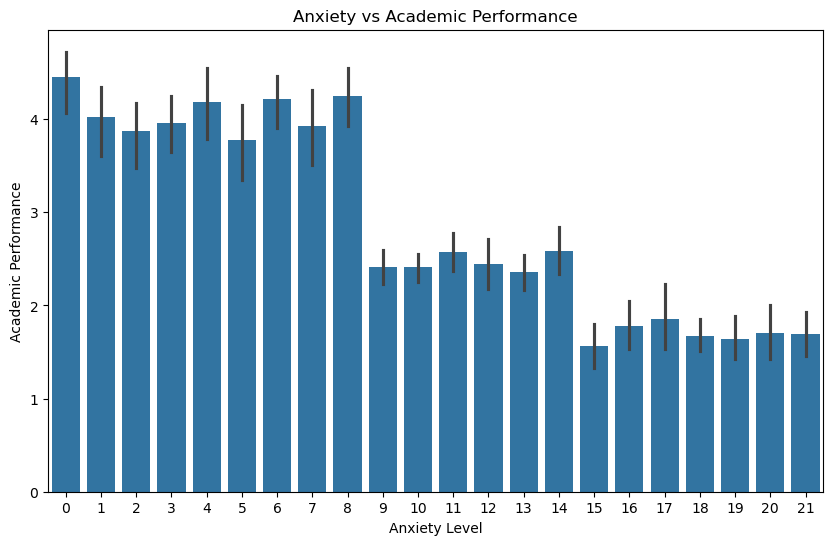

In [16]:
#Is there any realtion between academic perfomance and anxiety levels
vz.plot_barplot(data=secondary_data, x='anxiety_level', y='academic_performance', title='Anxiety vs Academic Performance', xlabel='Anxiety Level', ylabel='Academic Performance')

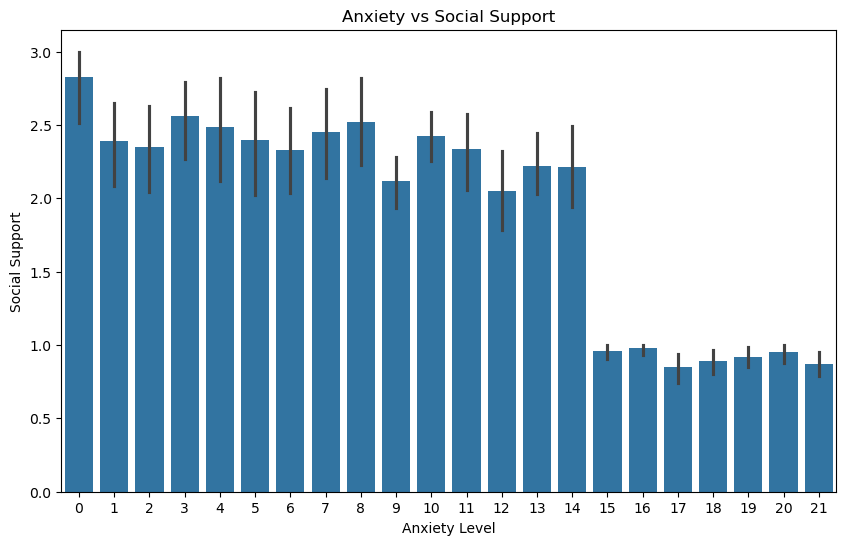

In [17]:
#Realtion bewteen extran curricular activities and anxiety levels
vz.plot_barplot(data=secondary_data, x='anxiety_level', y='social_support', title='Anxiety vs Social Support', xlabel='Anxiety Level', ylabel='Social Support')

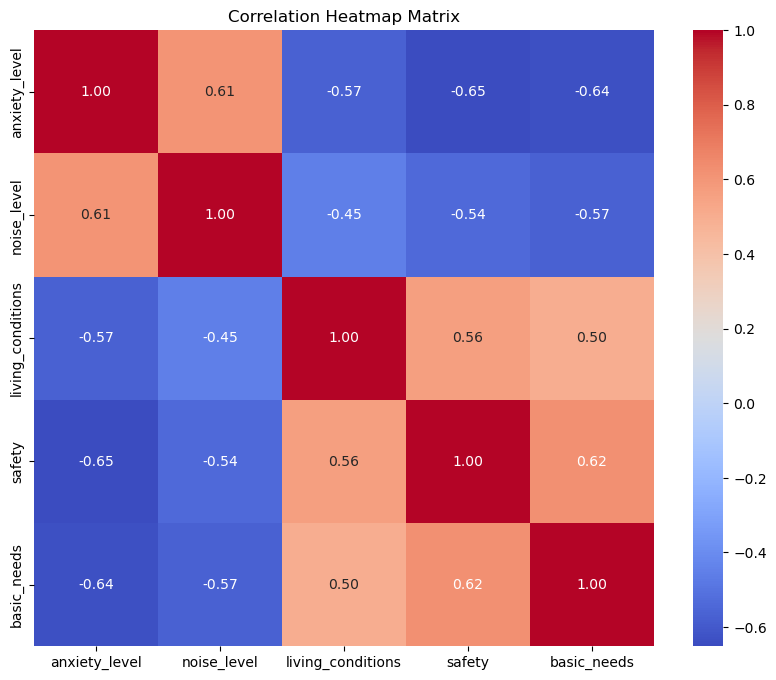

In [18]:
#Correlation between anxiety and noiselevel, living conditions, safety and basic needs
corr_matrix = secondary_data[['anxiety_level', 'noise_level', 'living_conditions', 'safety', 'basic_needs']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Matrix')
plt.show()

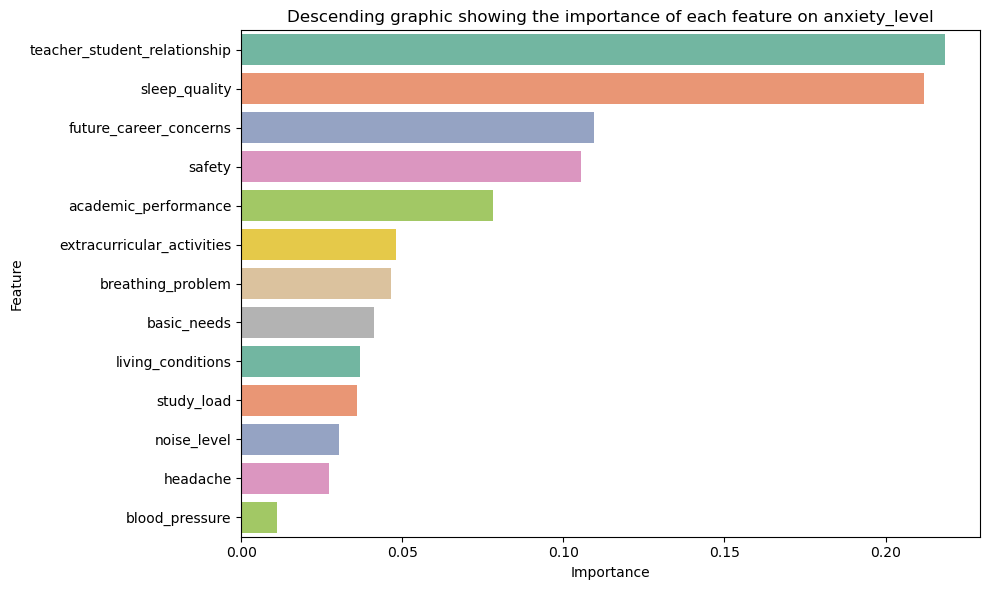

In [20]:
#Plotting relative importance of features to see how they contribute to anxiety levels. 
# And what features should we focus on
 #Listing out the factors except anxiety level itself
factors = {
    'Psychological': ['self_esteem', 'mental_health_history', 'depression'],
    'Physiological': ['headache', 'blood_pressure', 'sleep_quality', 'breathing_problem'],
    'Environmental': ['noise_level', 'living_conditions', 'safety', 'basic_needs'],
    'Academic': ['academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns'],
    'Social': ['social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']
}


feature_importance_dict = {}
for factor, factor_features in factors.items():
    factor_df = secondary_data[factor_features]
    # model for each factor
    factor_model = RandomForestRegressor(random_state=1)
    factor_model.fit(factor_df, secondary_data['anxiety_level'])
    
    feature_importances = factor_model.feature_importances_
    
    feature_importance_dict[factor] = {'Feature': factor_features, 'Importance': feature_importances}

consolidated_importance_df = pd.concat({k: pd.DataFrame(v) for k, v in feature_importance_dict.items()})

#The features we want to consider
features = [
    'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem',
    'noise_level', 'living_conditions', 'safety', 'basic_needs',
    'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'extracurricular_activities']

stress_model = RandomForestRegressor(random_state=1)
stress_model.fit(secondary_data[features], secondary_data['anxiety_level'])
feature_importances = stress_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

#Plotting a barplot to understand this
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), hue='Feature', palette='Set2', legend=False)
plt.title('Descending graphic showing the importance of each feature on anxiety_level')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()